# GMF — Task 3: TSLA 12‑Month Forecast (Colab, Offline‑First)
This notebook uses your Drive CSVs (no live yfinance calls), fits a SARIMAX model with statsmodels, produces a 12‑month (252 business days) forecast, saves a CSV/plot, and computes an expected annual return for Task 4.

In [1]:
# === 1) Pin a clean stack and HARD RESTART (run this cell ALONE first) ===
%pip install -q --force-reinstall \
  numpy==1.26.4 \
  scipy==1.11.4 \
  pandas==2.2.2 \
  statsmodels==0.14.2 \
  matplotlib==3.9.0

import IPython
IPython.Application.instance().kernel.do_shutdown(True)  # Colab will restart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232

{'status': 'ok', 'restart': True}

In [1]:
# === 2) Mount Drive and set project paths ===
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['GMF_DRIVE_PROJECT_DIR'] = '/content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization'
BASE_DIR   = os.environ['GMF_DRIVE_PROJECT_DIR']
DATA_DIR   = os.path.join(BASE_DIR, 'data')
OUT_PLOTS  = os.path.join(BASE_DIR, 'outputs', 'plots')
OUT_METRICS= os.path.join(BASE_DIR, 'outputs', 'metrics')
OUT_MODELS = os.path.join(BASE_DIR, 'outputs', 'models')
for d in [DATA_DIR, OUT_PLOTS, OUT_METRICS, OUT_MODELS]:
    os.makedirs(d, exist_ok=True)
print('BASE_DIR:', BASE_DIR)
print('DATA_DIR contents:', os.listdir(DATA_DIR))

Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization
DATA_DIR contents: ['TSLA_1d.csv', 'BND_1d.csv', 'SPY_1d.csv', 'returns_daily.csv', 'prices_adj_close.csv']


In [2]:
# === 3) Load combined prices or build from per‑ticker CSVs (NO network), clean TSLA ===
import pandas as pd, numpy as np, os

def load_adj_close(csv_path: str) -> pd.Series:
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    col = next((c for c in ['Adj Close','AdjClose','Adj_Close','Adjclose'] if c in df.columns), None)
    if col is None:
        raise ValueError(f"'Adj Close' not found in {csv_path}. Available: {list(df.columns)}")
    s = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    s = pd.to_numeric(s, errors='coerce')
    s.name = os.path.basename(csv_path).split('_')[0]
    return s

combined_path = os.path.join(DATA_DIR, 'prices_adj_close.csv')
if os.path.exists(combined_path):
    prices = pd.read_csv(combined_path, index_col=0, parse_dates=True)
    print('Loaded combined prices from', combined_path, '| shape:', prices.shape)
else:
    tickers = ['TSLA','BND','SPY']
    missing = [tk for tk in tickers if not os.path.exists(os.path.join(DATA_DIR, f'{tk}_1d.csv'))]
    if missing:
        raise FileNotFoundError(f"Missing {missing}. Run GMF_01_Setup_Data_Fetch.ipynb first to create data/*.csv (offline build).")
    adj = [load_adj_close(os.path.join(DATA_DIR, f'{tk}_1d.csv')) for tk in tickers]
    prices = pd.concat(adj, axis=1).sort_index().ffill().dropna(how='any')
    prices.to_csv(combined_path)
    print('Built combined prices and saved to', combined_path, '| shape:', prices.shape)

# Clean TSLA and set business‑day frequency, handling duplicates
tsla_raw = prices['TSLA'].copy()
tsla_raw.index = pd.to_datetime(tsla_raw.index, errors='coerce')
tsla_raw = pd.to_numeric(tsla_raw, errors='coerce').dropna().sort_index()
dupes = tsla_raw.index[tsla_raw.index.duplicated()].unique()
print('Duplicate date count:', len(dupes))
if len(dupes) > 0:
    tsla_raw = tsla_raw.groupby(level=0).last()  # or .mean()
bd_index = pd.bdate_range(tsla_raw.index.min(), tsla_raw.index.max(), freq='B')
tsla_b = tsla_raw.reindex(bd_index).ffill()
tsla_b.index.name = 'Date'
print('Series span:', tsla_b.index.min(), '→', tsla_b.index.max(), f'(n={len(tsla_b)})')
tsla_b.tail()

Loaded combined prices from /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/data/prices_adj_close.csv | shape: (2537, 3)
Duplicate date count: 1
Series span: 2015-07-01 00:00:00 → 2025-07-30 00:00:00 (n=2631)


,TSLA
Date,
2025-07-24,305.299988
2025-07-25,316.059998
2025-07-28,325.589996
2025-07-29,321.200012
2025-07-30,319.040009


Using saved order from Task 2: (0, 1, 2)
Final AIC: 17614.967712170528
Saved forecast CSV → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/tsla_forecast_12m.csv


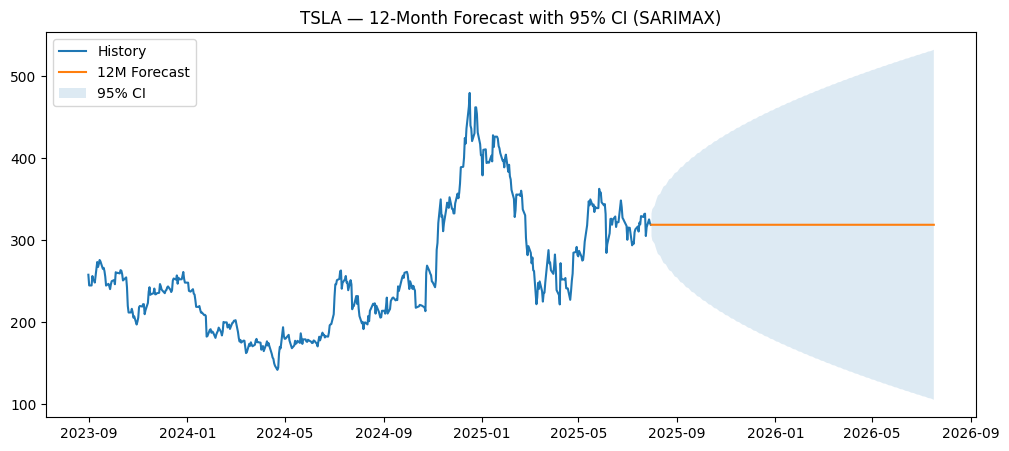

Saved plot → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/plots/tsla_12m_forecast.png
Expected daily: -0.000000  |  Annualized: -0.0059%
Saved expected return JSON → /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/tsla_expected_return_from_forecast.json


In [3]:
# === 4) Fit SARIMAX, forecast 12 months, save CSV/plot, compute expected return ===
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import joblib, json

model_path = os.path.join(OUT_MODELS, 'tsla_arima_statsmodels.pkl')
chosen_order = None
if os.path.exists(model_path):
    try:
        saved_res = joblib.load(model_path)
        if hasattr(saved_res.model, 'order'):
            chosen_order = saved_res.model.order
            print('Using saved order from Task 2:', chosen_order)
    except Exception as e:
        print('Warning: failed to load saved model:', e)
if chosen_order is None:
    candidates = [(0,1,1), (0,1,2), (1,1,1), (2,1,1)]
    best_aic, best_order = float('inf'), None
    for order in candidates:
        try:
            res = sm.tsa.SARIMAX(tsla_b, order=order, enforce_stationarity=False, enforce_invertibility=False).fit(maxiter=500, disp=False)
            if res.aic < best_aic:
                best_aic, best_order = res.aic, order
        except Exception:
            pass
    chosen_order = best_order
    print('Selected order:', chosen_order)

final_res = sm.tsa.SARIMAX(tsla_b, order=chosen_order, enforce_stationarity=False, enforce_invertibility=False).fit(maxiter=500, disp=False)
print('Final AIC:', final_res.aic)

steps = 252  # ~12 months (business days)
pred = final_res.get_forecast(steps=steps)
last_date = tsla_b.index.max()
future_index = pd.bdate_range(start=last_date + BDay(1), periods=steps, freq='B')
fc_mean = pd.Series(pred.predicted_mean.values, index=future_index, name='TSLA_Forecast')
conf_df = pred.conf_int(); conf_df.index = future_index; conf_df.columns = ['lower','upper']

# Save forecast CSV
out_csv = os.path.join(OUT_METRICS, 'tsla_forecast_12m.csv')
pd.concat([fc_mean, conf_df], axis=1).to_csv(out_csv)
print('Saved forecast CSV →', out_csv)

# Plot
plt.figure(figsize=(12,5))
hist = tsla_b.iloc[-500:] if len(tsla_b) > 500 else tsla_b
plt.plot(hist.index, hist.values, label='History')
plt.plot(fc_mean.index, fc_mean.values, label='12M Forecast')
plt.fill_between(fc_mean.index, conf_df['lower'], conf_df['upper'], alpha=0.15, label='95% CI')
plt.title('TSLA — 12‑Month Forecast with 95% CI (SARIMAX)')
plt.legend()
plot_path = os.path.join(OUT_PLOTS, 'tsla_12m_forecast.png')
plt.savefig(plot_path)
plt.show()
print('Saved plot →', plot_path)

# Expected return from forecast path (for Task 4 MPT)
fc_returns = fc_mean.pct_change().dropna()
exp_daily = fc_returns.mean(); exp_annual = exp_daily * 252
print(f'Expected daily: {exp_daily:.6f}  |  Annualized: {exp_annual:.4%}')
exp_json_path = os.path.join(OUT_METRICS, 'tsla_expected_return_from_forecast.json')
with open(exp_json_path, 'w') as f:
    json.dump({'expected_daily_return': float(exp_daily), 'expected_annual_return': float(exp_annual)}, f, indent=2)
print('Saved expected return JSON →', exp_json_path)